# Task C - Voronoi
## Divide city into N=10 cells


# Description

1. Select the initial set of 10 cell seed points. For this, you can use several criteria, such as being far away from frequent accident roads, being close to public transport, being evenly spread, etc. (explain your choice in the report).
2. Visualise the cells yield by your selection of seed points in a Voronoi diagram. What kind of Voronoi diagram (edge planar, node network, or edge points network) is most useful for this problem, and why?
3. Find 2 or 3 cells for which you can find at least one path (or more, if possible) that is (a) exactly 42 Km long, and (b) finishes at the same point where it starts. Visualise both the cells and the found paths.
4. Try to extend the previous step to all cells. Can you find at least one such a path for every cell?
5. If for steps 3-4 there were cells with no such path, what different options could you consider to increase the number of cells that include such paths? (Hint: think about the number and location of seed points; the size of the area under consideration; etc.) Choose one of such options, rep

## TODO
- Fix seeder points -> evenly spread OK
- what voronoi diagram??  edge planar, node network, or edge points network
- Find a path with end=start in each cell of 42 km

Importing all needed imports

In [ ]:
!pip install multiprocess

In [1]:
import networkx as nx
import osmnx as ox
from taskC.voronoi_tutorial_helpers import nodes_nearest_seed, get_seed_color, map_node_color_from_seed, map_edge_color_from_node
import pickle
from taskC.distance_metrices import FindMarathonDistance
import geopandas as gpd
from sklearn.cluster import KMeans

Loading the network and initialise global constant variables 

In [2]:
N_SEEDS = 10
# query_place_graph = ox.graph_from_place('Leeds, United Kingdom', network_type='drive')

with open('leeds_drive.pickle', 'rb') as f:
    query_place_graph = pickle.load(f)

What type of Voronoi diagram 

## Question 1 - Seed points with K-means for even distribution
Here sklearn library KMeans is used to extract evenly distributed nodes together with the nearest_node method from the osmnx to find the closest node from the (x,y) coordinates coming from k-means.

In [3]:
def get_seeds_with_kmeans(graph: nx.MultiDiGraph, num_seeds: int):
    coords = [(node, data['x'], data['y']) for node, data in graph.nodes(data=True)]
    gdf_nodes = gpd.GeoDataFrame(coords, columns=['node_id', 'x', 'y'])

    kmeans = KMeans(n_clusters=num_seeds, init='k-means++')
    kmeans.fit(gdf_nodes[['x', 'y']])

    unaligned_seeds = [(x, y) for x, y in kmeans.cluster_centers_]
    return align_seeds(graph, unaligned_seeds)


def align_seeds(graph: nx.MultiDiGraph, unaligned_seeds: list[tuple]) -> list:
    nearest_node_ids = []
    for seed in unaligned_seeds:
        lat, lon = seed
        nearest_node_ids.append(ox.nearest_nodes(graph, lat, lon, return_dist=False))
    return nearest_node_ids

In [4]:
all_nodes = list(query_place_graph.nodes)
seeds = get_seeds_with_kmeans(query_place_graph, N_SEEDS)
seeds

[1690928998,
 1543142533,
 6481110432,
 317600333,
 305698610,
 1560077,
 380917730,
 1955838372,
 248497502,
 395305638]

## Question 2 - Voronoi diagram
### Part 1 Voronoi cell generation and visualisation
The visualisation and the cell generations are from the week_6_sol.ipynb.

In [5]:
cells = nx.voronoi_cells(query_place_graph, seeds, weight='length')

In [6]:
black_color = (0.0, 0.0, 0.0, 1.0)
node_seed_dict = nodes_nearest_seed(query_place_graph, seeds, cells)
seed_colors = get_seed_color(seeds, black_color)
node_color_dict = map_node_color_from_seed(query_place_graph, node_seed_dict, seed_colors)
edge_colors = map_edge_color_from_node(query_place_graph, node_seed_dict, node_color_dict, black_color)

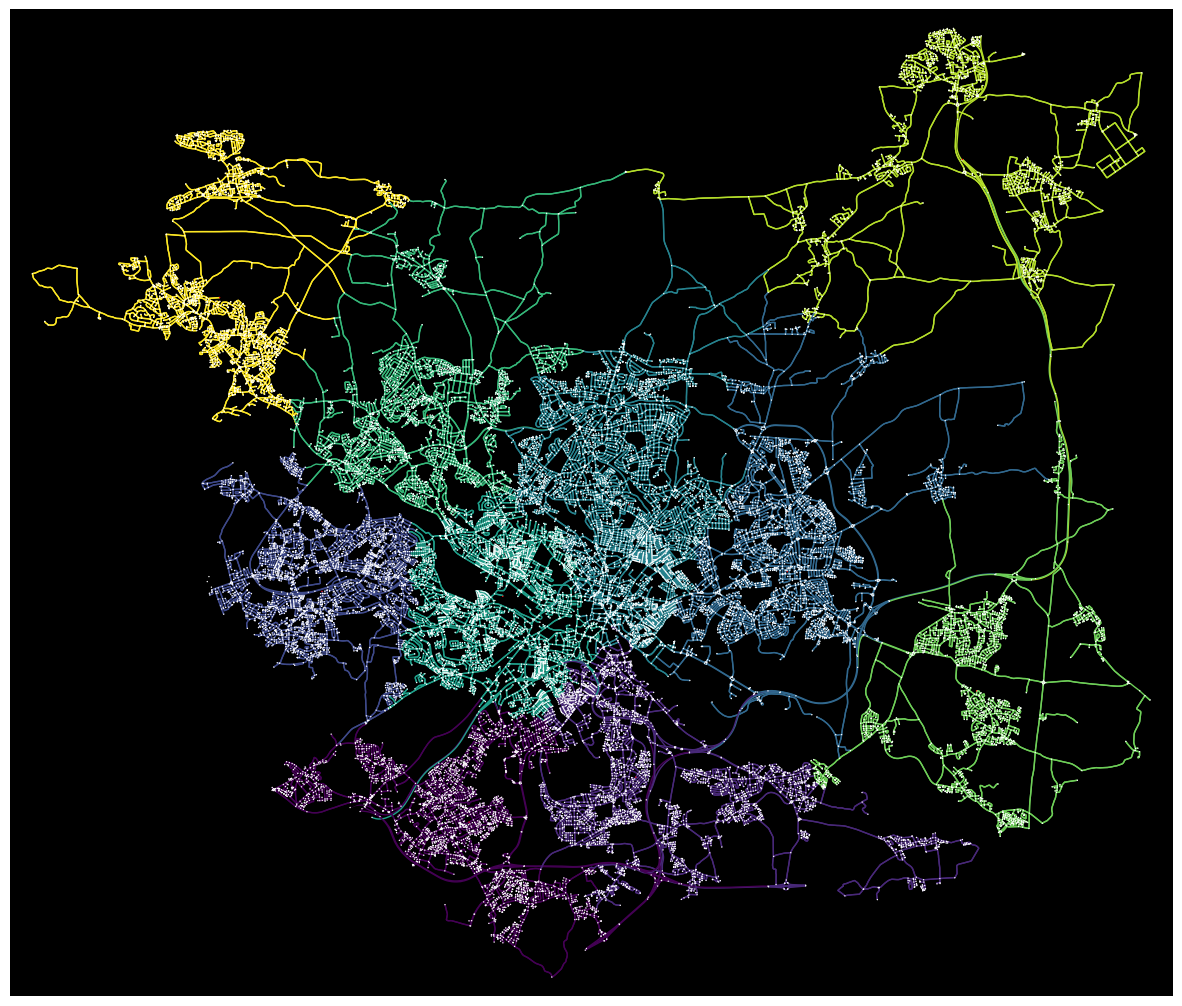

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [11]:
node_colors = ['r' if node in seeds else 'w' for node in all_nodes]
ox.plot.plot_graph(query_place_graph, edge_color=edge_colors, node_color=node_colors, bgcolor ='k', save=True, filepath='nvd.png', node_size=1, figsize=(15, 15))

 ### Part 2 - Voronoi diagram type
 What kind of Voronoi diagram (edge planar, node network, or edge points network) is most useful for this problem, and why?
 
edge planar -> can be drawn without its edges crossing
node network -> 
edge points network -> 

## Question 3 to 5 -  Marathon distance for each cell

  
5. Find 2 or 3 cells for which you can find at least one path (or more, if possible) that is (a) exactly 42 Km long, and (b) finishes at the same point where it starts. Visualise both the cells and the found paths.
4. Try to extend the previous step to all cells. Can you find at least one such a path for every cell?
5. If for steps 3-4 there were cells with no such path, what different options could you consider to increase the number of cells that include such paths? (Hint: think about the number and location of seed points; the size of the area under consideration; etc.) Choose one of such options, rep

In [8]:
all_nodes = list(query_place_graph.nodes)
seeds = get_seeds_with_kmeans(query_place_graph, N_SEEDS)
cells = nx.voronoi_cells(query_place_graph, seeds, weight='length')

marathon = FindMarathonDistance(query_place_graph, cells, seeds)
marathon.find_marathon_paths()
paths = marathon.get_marathon_paths()
paths

looking over subgraph nodes 3177
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 3898
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 3345
finding cycles...
searching for marathon lengths...
there is hope!
MARATHON!!
Found a marathon path[448708611, 448708540, 448708539, 448708536, 448708522, 448708524, 455592830, 448708519, 455592824, 455592823, 1978676415, 455592820, 455592818, 448708681, 455593527, 448708679, 455593531, 455593536, 317688907, 317688906, 455593363, 455593364, 455593534, 455593528, 455593366, 455593525, 455593368, 455592809, 455592807, 455592805, 31934400, 455593467, 455593480, 455593476, 455593475, 31933860, 444622874, 2005510123, 297092575, 60039522, 60039517, 444622804, 60039511, 60039508, 444622784, 444622942, 444622766, 60039492, 60039491, 444622758, 444623004, 60039489, 444623009, 444622690, 444622689, 4810013368, 3778839584, 444622702, 444622706, 444622697, 444622698, 444622699, 444622713, 444622700

[[448708611,
  448708540,
  448708539,
  448708536,
  448708522,
  448708524,
  455592830,
  448708519,
  455592824,
  455592823,
  1978676415,
  455592820,
  455592818,
  448708681,
  455593527,
  448708679,
  455593531,
  455593536,
  317688907,
  317688906,
  455593363,
  455593364,
  455593534,
  455593528,
  455593366,
  455593525,
  455593368,
  455592809,
  455592807,
  455592805,
  31934400,
  455593467,
  455593480,
  455593476,
  455593475,
  31933860,
  444622874,
  2005510123,
  297092575,
  60039522,
  60039517,
  444622804,
  60039511,
  60039508,
  444622784,
  444622942,
  444622766,
  60039492,
  60039491,
  444622758,
  444623004,
  60039489,
  444623009,
  444622690,
  444622689,
  4810013368,
  3778839584,
  444622702,
  444622706,
  444622697,
  444622698,
  444622699,
  444622713,
  444622700,
  297118461,
  297092578,
  444622533,
  444622656,
  444622532,
  444622531,
  444622511,
  444622530,
  444622554,
  441335458,
  444622559,
  441335395,
  441335411,
  53

Visualisation

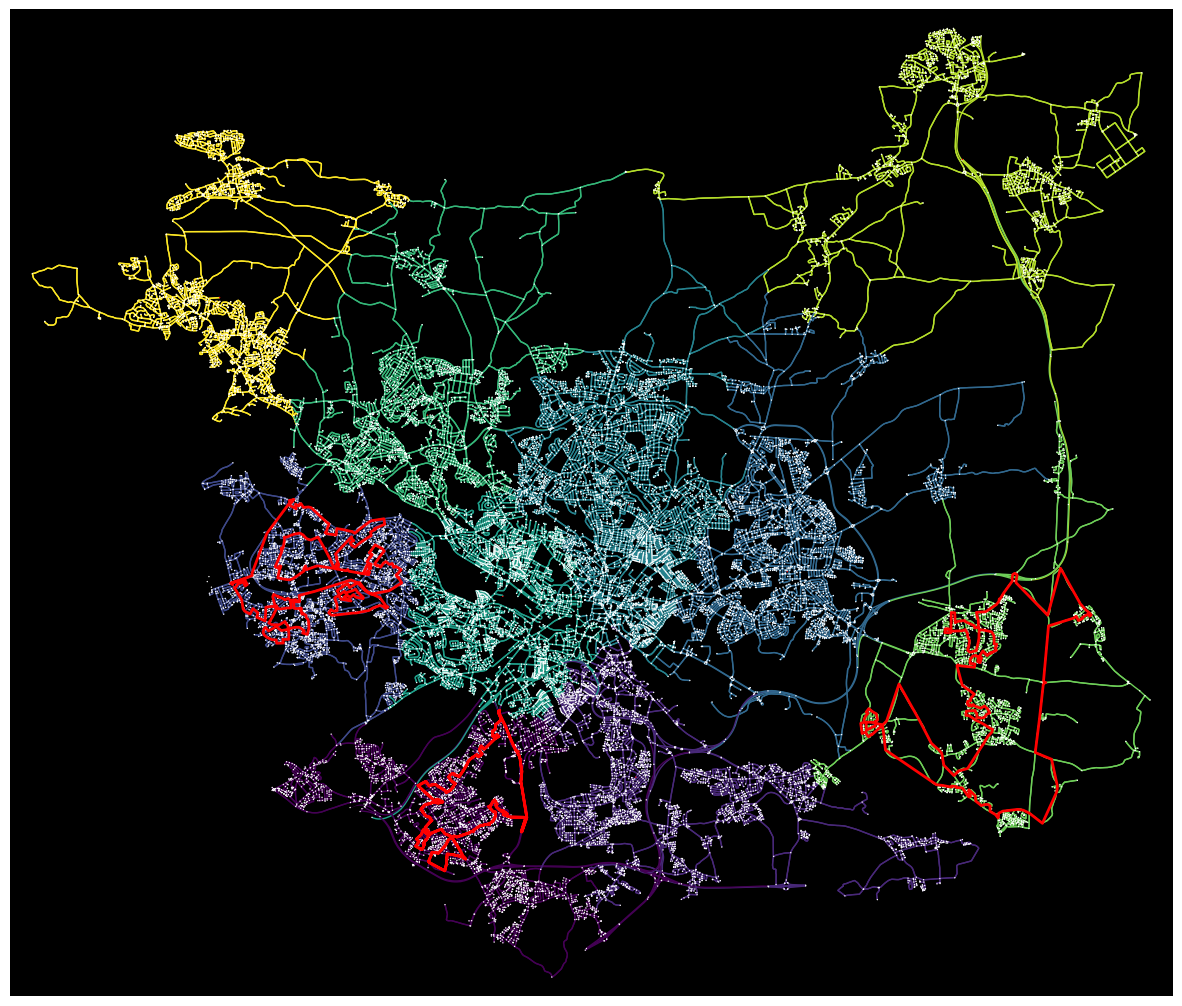

In [10]:
node_colors = ['r' if node in seeds else 'w' for node in all_nodes]
fig, ax = ox.plot.plot_graph(query_place_graph, edge_color=edge_colors, node_color=node_colors, bgcolor='k',
                   show=False, save=True, filepath='nvd.png', node_size=1, figsize=(15, 15))

for path in paths:
    x = [query_place_graph.nodes[node]['x'] for node in path]
    y = [query_place_graph.nodes[node]['y'] for node in path]
    ax.plot(x, y, color='red', linewidth=2)
